# Image text classification

### Necessary libraries

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras
from keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import misc
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score,
                             confusion_matrix)

### Loding data

- first we load images from data.npz file which is saved using the extract_data.py file.
- data.npz contains the train and dev images as well as 3 labels vectors corresponding to the classes of the documents, their languages, as well as their types (handwritten or printed).
- Images are standardized and have the same size (500,250).

Examples of images from dataset:


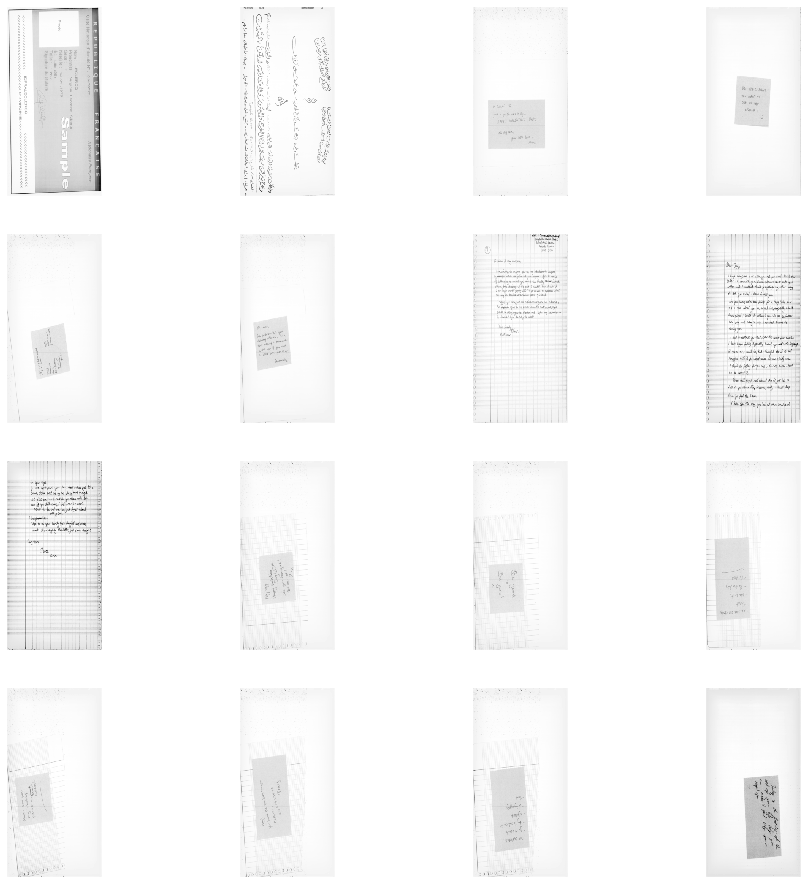

In [21]:
data = np.load('C:/Users/Ilyas/Desktop/M2_SID_SD/TER/data.npz')

Xtrain = data['Xtrain']
Xdev = data['Xdev']

print('Examples of images from dataset:')
# Plot the results
plt.figure(figsize=(16,16))
for i, image in enumerate(Xtrain[:16]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.axis('off')
    plt.xticks(())
    plt.yticks(())
plt.show()

### CNN Model

In [22]:
def cnn_model(num_classes,input_shape):
    
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.3))

    model.add(Conv2D(16, (3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])
    return model

### Class classification

- Now we use our cnn model to classify our images into 5 classes:

    - C1: blank or completed forms
    - C2: printed commercial documents but also manually commented
    - C3: handwritten private correspondence that may sometimes contain printed headers
    - C4: commercial correspondences printed but also manually commented
    - C5: other documents such as newspaper articles or plans ...

labels:                ['C1', 'C2', 'C3', 'C4', 'C5']
-----------------------------------------------------
count train elements:  [ 821 2470 1156  852  184]
count dev elements:    [193 485 216 169  47]
-----------------------------------------------------
Distribution of classes in train and dev dataset: 


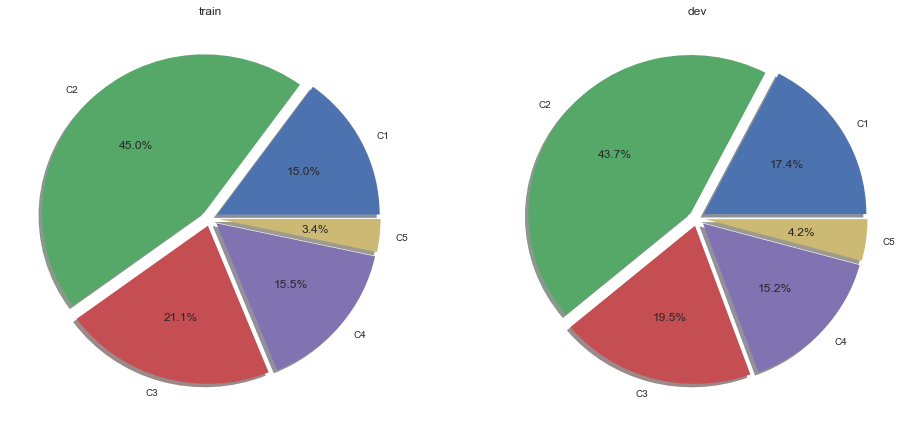

In [29]:
# Reshape X_test and X_train
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xdev = Xdev.reshape(Xdev.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)

# Loding labels of classes
ytrain = data['ytrain_class']
ydev = data['ydev_class']
labels = ['C1','C2','C3','C4','C5']

# number of element in each class
unique, counts_train = np.unique(ytrain, return_counts=True)
unique, counts_dev = np.unique(ydev, return_counts=True)

print('labels:               ',labels)
print('-----------------------------------------------------')
print('count train elements: ',counts_train)
print('count dev elements:   ',counts_dev)
print('-----------------------------------------------------')
print('Distribution of classes in train and dev dataset: ')
explode = (0.05, 0.05, 0.05, 0.05 ,0.05)  
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title('train')
plt.pie(counts_train, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.subplot(2, 2, 2)
plt.title('dev')
plt.pie(counts_dev, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.show()

- Lets train our model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 500, 250, 8)       80        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 125, 62, 8)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 125, 62, 8)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 125, 62, 16)       1168      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 31, 16)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 62, 31, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 62, 31, 32)        4640      
__________

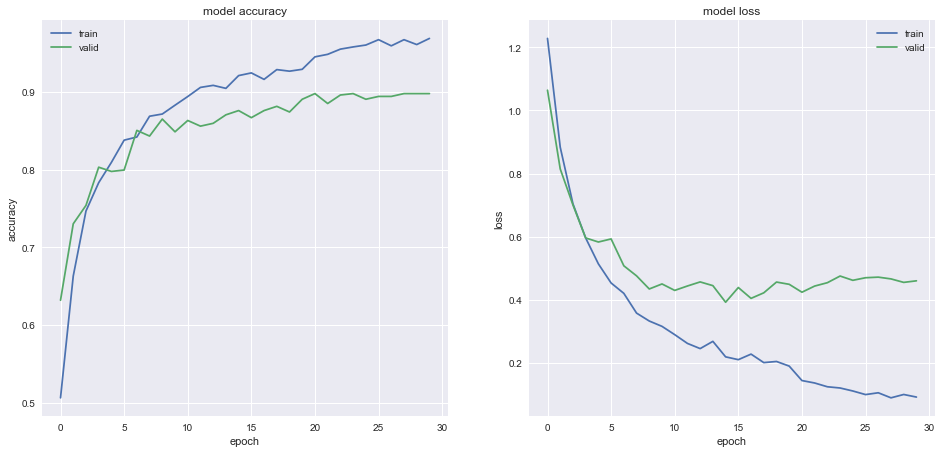

In [24]:
# Sets parameters
VALIDATION_SPLIT = .1
num_classes = 5
batch_size = 16
epochs = 30

# Convert class vectors to binary class matrices
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create callbacks
filepath = 'weight_cnn_class' + '.hdf5'
multi_checkpointer = ModelCheckpoint(filepath=filepath, verbose=0)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=0.2)

# Training model
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = cnn_model(num_classes,input_shape)
model.summary()
history = model.fit(Xtrain, ytrain,
                    batch_size=batch_size,
                    epochs=epochs, verbose=0,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=[multi_checkpointer,multi_lr_reduction])

# Plot results
plt.figure(figsize=(16,16))

# summarize history for accuracy
plt.subplot(2, 2, 1)
plt.title('train')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

# summarize history for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


- Performances

Labels:                ['C1', 'C2', 'C3', 'C4', 'C5']
-----------------------------------------------------
Count pred elements:  [195 486 231 166  32]
Count dev elements:    [193 485 216 169  47]
-----------------------------------------------------
Distribution of classes in predicted and dev dataset: 


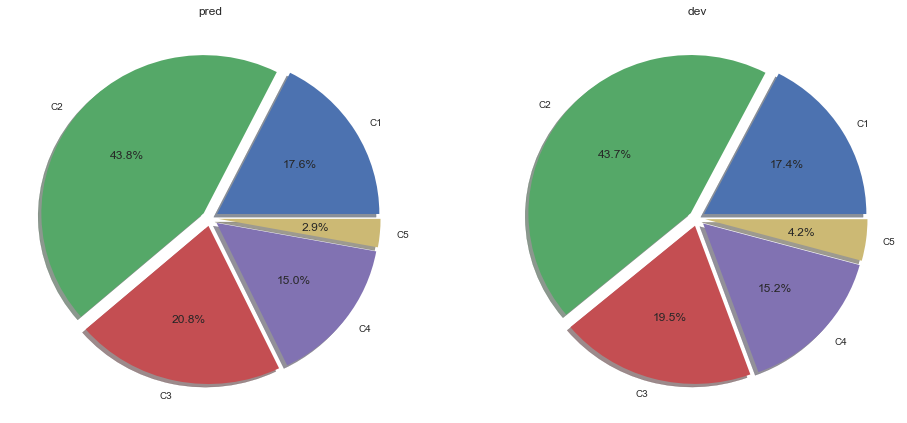

-----------------------------------------------------
Test accuracy:     0.92   
Test error:     0.08   
------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.95      0.96      0.96       193
        1.0       0.92      0.92      0.92       485
        2.0       0.88      0.94      0.91       216
        3.0       0.93      0.91      0.92       169
        4.0       0.78      0.53      0.63        47

avg / total       0.91      0.92      0.91      1110

------------------------------------------------------
Confusion matrix: 



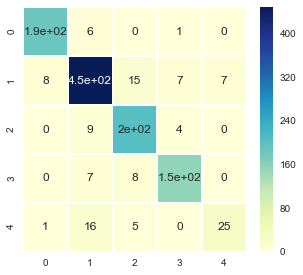

In [25]:
# Matrice de probabilitées d'appartenance à chaque classe
ypred = model.predict_classes(Xdev)
ydev = data['ydev_class']

# number of element in each class
unique, counts_pred = np.unique(ypred, return_counts=True)
unique, counts_dev = np.unique(ydev, return_counts=True)

print('Labels:               ',labels)
print('-----------------------------------------------------')
print('Count pred elements: ',counts_pred)
print('Count dev elements:   ',counts_dev)
print('-----------------------------------------------------')
print('Distribution of classes in predicted and dev dataset: ')
explode = (0.05, 0.05, 0.05, 0.05 ,0.05)  
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title('pred')
plt.pie(counts_pred, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.subplot(2, 2, 2)
plt.title('dev')
plt.pie(counts_dev, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.show()

# Performance
print('-----------------------------------------------------')
print("Test accuracy: ",'{:^10.2f}'.format(accuracy_score(ypred, ydev)))
print("Test error: ",'{:^10.2f}'.format(1-accuracy_score(ypred, ydev)))
print('------------------------------------------------------')
p, r, f1, s = precision_recall_fscore_support(ydev, ypred, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(ydev) 
                                                      if x not in ['CSDECMOTV']])

print(classification_report(ydev, ypred, labels=[x for x in 
                                                       np.unique(ydev) 
                                                       if x not in ['CSDECMOTV']]))
print('------------------------------------------------------')
print('Confusion matrix: \n')
sns.set(rc={'figure.figsize':(5,4.5)})
cm_data = confusion_matrix(ydev, ypred)
cm = sns.heatmap(cm_data, annot=True, cmap="YlGnBu", linewidths=.5)

### Language classification

- we classify our images into 3 languages:
    - fr: french
    - ar: arabic
    - en: english

labels:                ['fr', 'ar', 'en']
-----------------------------------------------------
count train elements:  [2795 1337 1351]
count dev elements:    [570 263 277]
-----------------------------------------------------
Distribution of classes in train and dev dataset: 


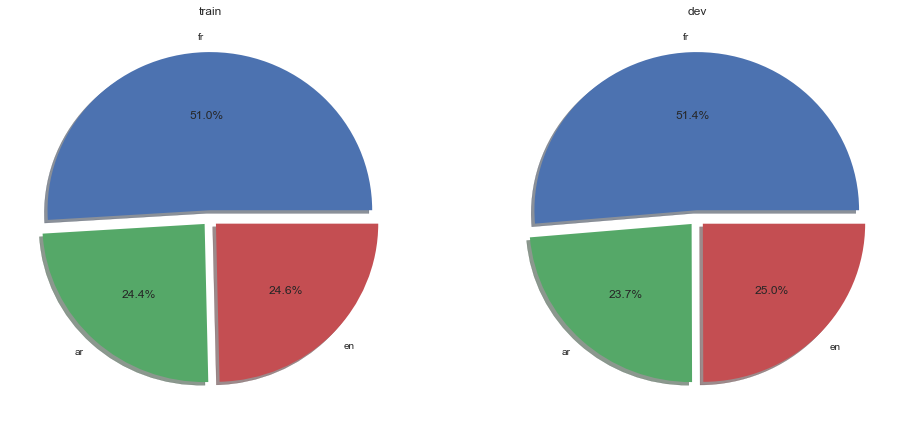

In [26]:
# Loding labels of classes
ytrain = data['ytrain_language']
ydev = data['ydev_language']
labels = ['fr','ar', 'en']

# number of element in each class
unique, counts_train = np.unique(ytrain, return_counts=True)
unique, counts_dev = np.unique(ydev, return_counts=True)

print('labels:               ',labels)
print('-----------------------------------------------------')
print('count train elements: ',counts_train)
print('count dev elements:   ',counts_dev)
print('-----------------------------------------------------')
print('Distribution of classes in train and dev dataset: ')
explode = (0.05, 0.05 ,0.05)  
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title('train')
plt.pie(counts_train, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.subplot(2, 2, 2)
plt.title('dev')
plt.pie(counts_dev, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.show()

- Training model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 500, 250, 8)       80        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 125, 62, 8)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 125, 62, 8)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 125, 62, 16)       1168      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 31, 16)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 62, 31, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 62, 31, 32)        4640      
__________

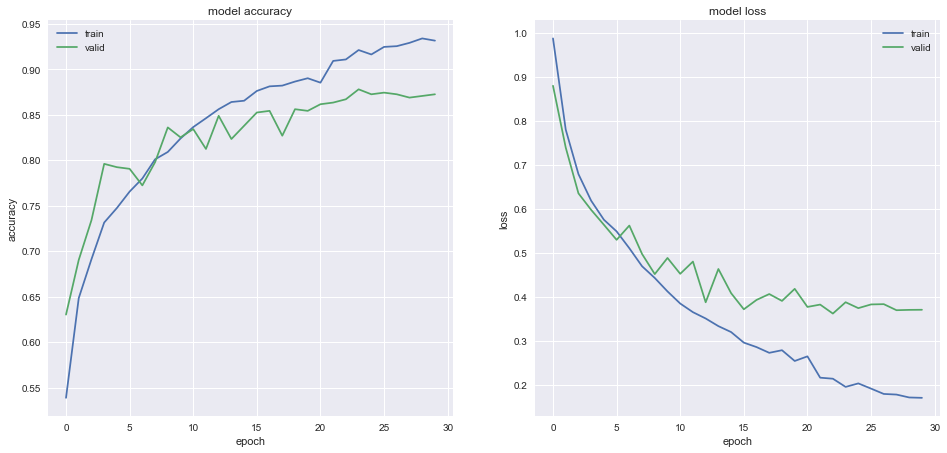

In [27]:
VALIDATION_SPLIT = .1
batch_size = 16
epochs = 30
num_classes = 3

# Convert class vectors to binary class matrices
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create callbacks
filepath = 'weight_cnn_lang' + '.hdf5'
multi_checkpointer = ModelCheckpoint(filepath=filepath, verbose=0)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=0.2)

# Training model
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = cnn_model(num_classes,input_shape)
model.summary()
history = model.fit(Xtrain, ytrain,
                    batch_size=batch_size,
                    epochs=epochs, verbose=0,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=[multi_checkpointer,multi_lr_reduction])

# Plot results
plt.figure(figsize=(16,16))

# summarize history for accuracy
plt.subplot(2, 2, 1)
plt.title('train')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

# summarize history for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

- Performances

Labels:                ['fr', 'ar', 'en']
-----------------------------------------------------
Count pred elements:  [582 255 273]
Count dev elements:    [570 263 277]
-----------------------------------------------------
Distribution of classes in predicted and dev dataset: 


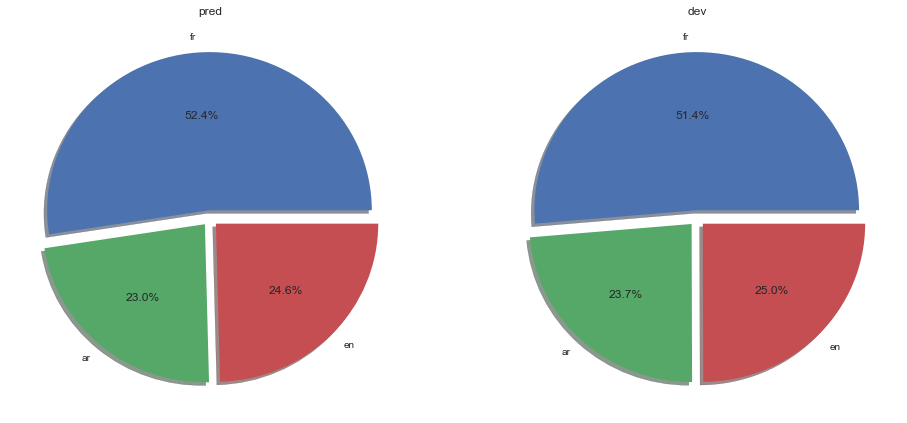

-----------------------------------------------------
Test accuracy:     0.89   
Test error:     0.11   
------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.90      0.92      0.91       570
        1.0       0.96      0.94      0.95       263
        2.0       0.82      0.81      0.82       277

avg / total       0.89      0.89      0.89      1110

------------------------------------------------------
Confusion matrix: 



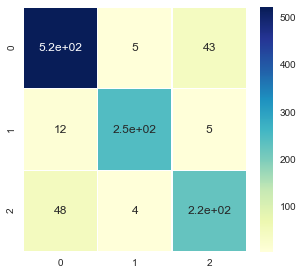

In [28]:
# Matrice de probabilitées d'appartenance à chaque classe
ypred = model.predict_classes(Xdev)
ydev = data['ydev_language']

# Plot the statistics
# number of element in each class
unique, counts_pred = np.unique(ypred, return_counts=True)
unique, counts_dev = np.unique(ydev, return_counts=True)

print('Labels:               ',labels)
print('-----------------------------------------------------')
print('Count pred elements: ',counts_pred)
print('Count dev elements:   ',counts_dev)
print('-----------------------------------------------------')
print('Distribution of classes in predicted and dev dataset: ')
explode = (0.05, 0.05 ,0.05)  
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title('pred')
plt.pie(counts_pred, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.subplot(2, 2, 2)
plt.title('dev')
plt.pie(counts_dev, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.show()

# Performance
print('-----------------------------------------------------')
print("Test accuracy: ",'{:^10.2f}'.format(accuracy_score(ypred, ydev)))
print("Test error: ",'{:^10.2f}'.format(1-accuracy_score(ypred, ydev)))
print('------------------------------------------------------')
p, r, f1, s = precision_recall_fscore_support(ydev, ypred, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(ydev) 
                                                      if x not in ['CSDECMOTV']])

print(classification_report(ydev, ypred, labels=[x for x in 
                                                       np.unique(ydev) 
                                                       if x not in ['CSDECMOTV']]))
print('------------------------------------------------------')
print('Confusion matrix: \n')
sns.set(rc={'figure.figsize':(5,4.5)})
cm_data = confusion_matrix(ydev, ypred)
cm = sns.heatmap(cm_data, annot=True, cmap="YlGnBu", linewidths=.5)

### Type classification

- We classify images in 3 types :
    - handwritten
    - printed
    - mixed

labels:                ['print', 'hand', 'mixte']
-----------------------------------------------------
count train elements:  [1714  801 2968]
count dev elements:    [372 137 601]
-----------------------------------------------------
Distribution of classes in predicted and dev dataset: 


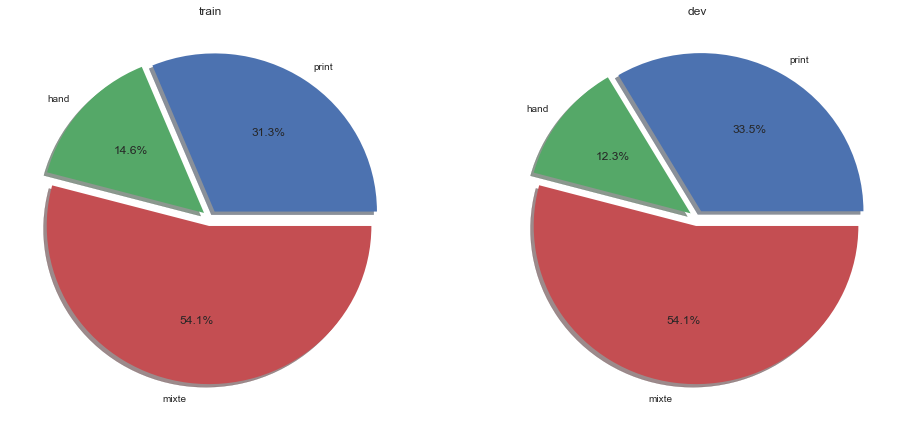

In [10]:
# Loding labels of classes
ytrain = data['ytrain_type']
ydev = data['ydev_type']
labels = ['print','hand','mixte']

# number of element in each class
unique, counts_train = np.unique(ytrain, return_counts=True)
unique, counts_dev = np.unique(ydev, return_counts=True)

print('labels:               ',labels)
print('-----------------------------------------------------')
print('count train elements: ',counts_train)
print('count dev elements:   ',counts_dev)
print('-----------------------------------------------------')
print('Distribution of classes in predicted and dev dataset: ')
explode = (0.05, 0.05 ,0.05)  
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title('train')
plt.pie(counts_train, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.subplot(2, 2, 2)
plt.title('dev')
plt.pie(counts_dev, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.show()

- Training model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 500, 250, 8)       80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 166, 83, 8)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 166, 83, 8)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 166, 83, 16)       1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 83, 41, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 83, 41, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 83, 41, 32)        4640      
__________

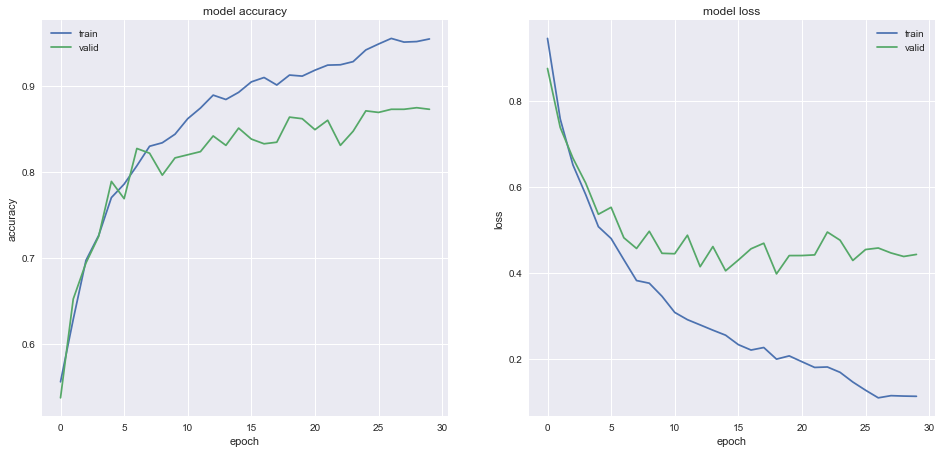

In [11]:
VALIDATION_SPLIT = .1
batch_size = 16
epochs = 30
num_classes = 3

# Convert class vectors to binary class matrices
ytrain = keras.utils.to_categorical(ytrain, num_classes)

# Create callbacks
filepath = 'weight_cnn_type' + '.hdf5'
multi_checkpointer = ModelCheckpoint(filepath=filepath, verbose=0)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=0.2)

# Training model
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = cnn_model(num_classes,input_shape)
model.summary()
history = model.fit(Xtrain, ytrain,
                    batch_size=batch_size,
                    epochs=epochs, verbose=0,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=[multi_checkpointer,multi_lr_reduction])

# Plot results
plt.figure(figsize=(16,16))

# summarize history for accuracy
plt.subplot(2, 2, 1)
plt.title('train')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

# summarize history for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


- Performances

Labels:                ['print', 'hand', 'mixte']
-----------------------------------------------------
Count pred elements:  [390 124 596]
Count dev elements:    [372 137 601]
-----------------------------------------------------
Distribution of classes in predicted and dev dataset: 


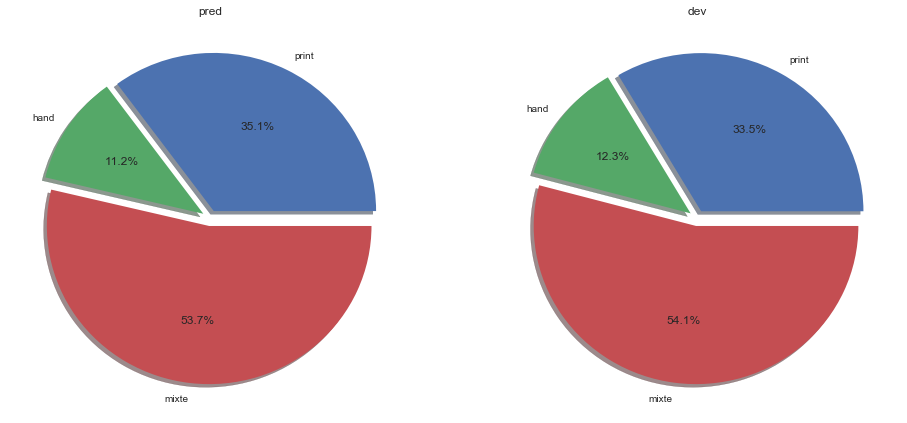

-----------------------------------------------------
Test accuracy:     0.84   
Test error:     0.16   
------------------------------------------------------
             precision    recall  f1-score   support

        0.0       0.79      0.83      0.81       372
        1.0       0.88      0.80      0.84       137
        2.0       0.87      0.86      0.86       601

avg / total       0.84      0.84      0.84      1110

------------------------------------------------------
Confusion matrix: 



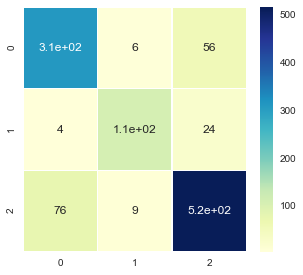

In [12]:
# Matrice de probabilitées d'appartenance à chaque classe
ypred = model.predict_classes(Xdev)
ydev = data['ydev_type']

# Plot the statistics
# number of element in each class
unique, counts_pred = np.unique(ypred, return_counts=True)
unique, counts_dev = np.unique(ydev, return_counts=True)

print('Labels:               ',labels)
print('-----------------------------------------------------')
print('Count pred elements: ',counts_pred)
print('Count dev elements:   ',counts_dev)
print('-----------------------------------------------------')
print('Distribution of classes in predicted and dev dataset: ')
explode = (0.05, 0.05 ,0.05)  
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.title('pred')
plt.pie(counts_pred, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.subplot(2, 2, 2)
plt.title('dev')
plt.pie(counts_dev, explode=explode,labels = labels, autopct='%1.1f%%',shadow = True)
plt.show()

# Performance
print('-----------------------------------------------------')
print("Test accuracy: ",'{:^10.2f}'.format(accuracy_score(ypred, ydev)))
print("Test error: ",'{:^10.2f}'.format(1-accuracy_score(ypred, ydev)))
print('------------------------------------------------------')
p, r, f1, s = precision_recall_fscore_support(ydev, ypred, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(ydev) 
                                                      if x not in ['CSDECMOTV']])

print(classification_report(ydev, ypred, labels=[x for x in 
                                                       np.unique(ydev) 
                                                       if x not in ['CSDECMOTV']]))
print('------------------------------------------------------')
print('Confusion matrix: \n')
sns.set(rc={'figure.figsize':(5,4.5)})
cm_data = confusion_matrix(ydev, ypred)
cm = sns.heatmap(cm_data, annot=True, cmap="YlGnBu", linewidths=.5)